### Step 1. 데이터 수집하기
---
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용한다.

### Step 2. 데이터 전처리하기
---
>영어 데이터와는 전혀 다른 데이터인만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.


In [1]:
import os
import re
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from model import Transformer
import matplotlib.pyplot as plt

In [2]:
path = os.getenv("HOME") + "/project/E21_Transformer/data/ChatbotData.csv"
data = pd.read_csv(path)

In [3]:
data.sample(5)

,Q,A,label
10934,이제 내 짝남 못봐. 군대 가거든.,서운하겠어요.,2
7491,이별극복후 새로운 설렘,좋은 소식이네요.,1
8827,희망고문,아예 생각을 하지 말아요.,1
2328,삼겹살 구워야지,맛있겠네요.,0
865,내가 좋아하는 사람과 나를 좋아해주는 사람,그런 사람들이 있어 부러워요.,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [5]:
len(data)

11823

In [6]:
data['Q'][1149]

'다크서클 턱밑에 있다.'

In [7]:
def preprocess_sentence(sentence):
    #구두점과 단어 사이에 공백 만들기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    #지정한 문자 외 제거
    sentence = re.sub(r"[^0-9ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", r" ", sentence)
    sentence = sentence.strip()
    return sentence

In [8]:
#Test preprocess_sentence function.
print(preprocess_sentence("Youtube 보고 싶은데, 123모여서 같이봐도 돼??^^"))

Youtube 보고 싶은데 , 123모여서 같이봐도 돼 ? ?


In [9]:
def load_conversations(data):
    inputs, outputs = [], []
    for i in range(len(data)):
        inputs.append(preprocess_sentence(data['Q'][i]))
        outputs.append(preprocess_sentence(data['A'][i]))
    assert len(inputs) == len(outputs) and len(inputs) == len(data)
    return inputs, outputs

In [10]:
questions, answers = load_conversations(data)

In [11]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [12]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


### Step 3. SubwordTextEncoder 사용하기

#### 병렬 데이터 전처리

In [13]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(questions+answers,target_vocab_size=2**13)

In [14]:
START_TOKEN,END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [15]:
print("START_TOKEN의 번호 : ", [tokenizer.vocab_size])
print("END_TOKEN의 번호 : ", [tokenizer.vocab_size + 1])

START_TOKEN의 번호 :  [8170]
END_TOKEN의 번호 :  [8171]


In [16]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


In [17]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('원래 질문 문장 샘플 : {}'.format(questions[21]))
print('원래 답변 문장 샘플 : {}'.format(answers[21]))
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

원래 질문 문장 샘플 : 가스비 장난 아님
원래 답변 문장 샘플 : 다음 달에는 더 절약해봐요 .
정수 인코딩 후의 21번째 질문 샘플: [5762, 610, 2490, 4163]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7510, 7, 6273, 97, 1]


In [18]:
START_TOKEN + tokenizer.encode(questions[21]) + END_TOKEN

[8170, 5762, 610, 2490, 4163, 8171]

각 단어에 정수가 부여된 Vocabulay를 기준으로  
`단어 시퀀스` => `정수 시퀀스`  
로 인코딩 된 결과를 확인할 수 있다. 위의 결과와 마찬가지로 모든 질문과 답변 셋에 대해서 `정수 인코딩`을 수행한다.  
\+ 문장의 최대길이 정하기 + Padding 하기

In [19]:
MAX_LENGTH = 30
print(MAX_LENGTH)

30


In [20]:
def tokenize_and_filter(inputs, outputs):
    #정수화된 인풋과, 정수화된 아웃풋을 담을 그릇
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        #최대 길이 이하인 데이터만 사용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    #최대 길이로 모든 데이터셋 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding = 'post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [21]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 샘플 개수: 11822
필터링 후의 샘플 개수: 11822


#### Teacher Forcing
창의적이고 데이터로 부터 독립적인 문장을 생성하기에는 힘들겠지만,  
적어도 입력된 문장에 가까운 문장을 생성하게 유도함으로써  
생성 문장의 질을 높인다.

In [22]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs' : questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

In [24]:
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Step 4. 모델 구성하기

In [45]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 256 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

In [46]:
transformers = Transformer()
model = transformers.transformer(vocab_size=VOCAB_SIZE,
                                num_layers=NUM_LAYERS,
                                units=UNITS,
                                d_model=D_MODEL,
                                num_heads=NUM_HEADS,
                                dropout=DROPOUT)
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    2092032     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### Step 5. 모델 평가하기
  
#### Loss function

In [47]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

#### Learning rate

In [48]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

#### 모델 컴바인

In [50]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [51]:
EPOCHS = 50

model.fit(dataset, epochs=EPOCHS,validation_batch_size=12, verbose=1)

Epoch 1/50
185/185 [==============================] - 8s 42ms/step - loss: 1.9790 - accuracy: 0.0332
Epoch 2/50
185/185 [==============================] - 8s 42ms/step - loss: 1.6023 - accuracy: 0.0663
Epoch 3/50
185/185 [==============================] - 8s 42ms/step - loss: 1.3521 - accuracy: 0.0679
Epoch 4/50
185/185 [==============================] - 8s 42ms/step - loss: 1.2507 - accuracy: 0.0728
Epoch 5/50
185/185 [==============================] - 8s 42ms/step - loss: 1.1724 - accuracy: 0.0769
Epoch 6/50
185/185 [==============================] - 8s 43ms/step - loss: 1.0902 - accuracy: 0.0825
Epoch 7/50
185/185 [==============================] - 8s 43ms/step - loss: 0.9959 - accuracy: 0.0907
Epoch 8/50
185/185 [==============================] - 8s 43ms/step - loss: 0.8886 - accuracy: 0.1018
Epoch 9/50
185/185 [==============================] - 8s 43ms/step - loss: 0.7686 - accuracy: 0.1161
Epoch 10/50
185/185 [==============================] - 8s 43ms/step - loss: 0.6438 - accura

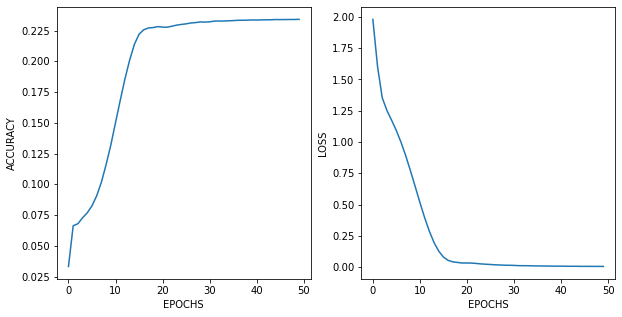

In [52]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.plot(model.history.history['accuracy'])

plt.subplot(122)
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.plot(model.history.history['loss'])

#### 챗봇 테스트하기

In [53]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞 뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [54]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [55]:
sentence_generation("안녕?")

입력 : 안녕?
출력 : 안녕하세요


'안녕하세요'

In [74]:
sentence_generation("누구세요?")

입력 : 누구세요?
출력 : 저는 


'저는 '

In [57]:
sentence_generation("할 수 있어?")

입력 : 할 수 있어?
출력 : 그럼요


'그럼요'

In [78]:
sentence_generation("밖에 먼지가 너무 많아")

입력 : 밖에 먼지가 너무 많아
출력 : 얼른 


'얼른 '